---
title: "Some figures to illustrate beam injection and accumulation"
date: 2022-02-11
author: Austin Hoover
categories: [visualization]
image: injection.gif

---

## Charge-exchange injection 

One method to create high-intensity hadron beams is charge-exchange injection: negatively charged particles are repeatedly accelerated in a linear accelerator (linac) and injected into a circular accelerator (ring), accumulating charge in the ring over time. I created a simple animation to visualize this process.

In [3]:
import numpy as np
from scipy.stats import truncnorm
from matplotlib import animation
from matplotlib import pyplot as plt
import proplot as pplt
import seaborn as sns

In [2]:
#| echo: false
pplt.rc['animation.html'] = 'jshtml'
pplt.rc['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
pplt.rc['cmap.discrete'] = False
pplt.rc['figure.facecolor'] = 'None'
pplt.rc['grid'] = False
pplt.rc['savefig.dpi'] = 150

And some helper functions.

In [4]:
def rotation_matrix(angle):
    """Clockwise rotation matrix."""
    cs, sn = np.cos(angle), np.sin(angle)
    return np.array([[cs, sn], [-sn, cs]])


def apply(M, X):
    """Apply matrix `M` to each row of `X`."""
    return np.apply_along_axis(lambda row: np.matmul(M, row), 1, X)

The Bunch class stores the $x$, $x'$, and $z$ coordinates, which are measured relative to the bunch centroid. It also stores $s$, the location of the bunch center along the beam line. To transport the beam, we just increase $s$. We'll let the particles perform harmonic oscillations in the transverse plane. The only tricky part is to convert to an aerial view and to bend the circulating beam around the ring.

In [5]:
class Bunch:
    """Class to store bunch coordinates.

    Attributes
    ----------
    X : ndarray, shape (n, 3)
        The bunch coordinates (x, x', z).
    s : The location of the bunch center along the beamline.
    """

    def __init__(self, n, zrms=0.1, aspect=0.1):
        """Constructor.

        n : int
            The number of particles in the bunch.
        zrms : float
            The rms width of the z distribution.
        aspect : float
            The rms width of the x and x' distribution relative to `zrms`.
        """
        self.n, self.zrms, self.aspect = n, zrms, aspect
        self.X = np.random.normal(
            scale=[aspect * zrms, aspect * zrms, zrms],
            size=(n, 3),
        )
        self.s = 0.0

    def transport(self, distance, period_length):
        """Propagate the bunch along the beamline.

        Parameters
        ----------
        distance : float
            The distance along the beamline.
        period_length : float
            The period length of transverse focusing. The particles perform
            transverse harmonic oscillations.
        """
        self.X[:, :2] = apply(
            rotation_matrix(2.0 * np.pi * (distance / period_length)),
            self.X[:, :2],
        )
        self.s += distance

    def global_coords_line(self, x0=0.0, y0=0.0, angle=0.0):
        """Return global (top-view) coordinates for straight-line transport.

        Parameters
        ----------
        x0, y0 : float
            Initial bunch centroid coordinates.
        angle : float
            The angle of the beamline.

        Returns
        -------
        ndarray, same shape as self.X
            The top-view coordinates.
        """
        # The initial bunch is vertical when viewed from above. Point it
        # in the right direction.
        R = rotation_matrix(angle + 0.5 * np.pi)
        x, y = apply(R, self.X[:, [0, 2]]).T
        # Slide along the beamline to the correct location.
        x += x0 + self.s * np.cos(angle)
        y += y0 + self.s * np.sin(angle)
        coords = np.vstack([x, y]).T
        return coords

    def global_coords_ring(self, ring_length):
        """Return global (top-view) coordinates for circular transport.

        Parameters
        ----------
        ring_length : float
            The circumference of the ring. We assume it is centered
            on the origin.

        Returns
        -------
        ndarray, same shape as self.X
            The top-view coordinates.
        """
        # The initial bunch is vertical when viewed from above. Make it
        # horizontal.
        R = rotation_matrix(0.5 * np.pi)
        x, y = apply(R, self.X[:, [0, 2]]).T
        # Put the bunch at the top of the ring and account for ring curvature.
        ring_radius = ring_length / (2.0 * np.pi)
        y += np.sqrt(ring_radius**2 - x**2)
        # Slide along the beamline to the correct location.
        phi = 2.0 * np.pi * (self.s % ring_length) / ring_length
        R = rotation_matrix(phi)
        coords = np.vstack([x, y]).T
        coords = apply(R, coords)
        return coords

To run the "simulation", we will create two bunches: the first circulates in the ring, and the second is repeatedly stepped through the linac. After one revolution, the second bunch gives its particles to the first bunch.

In [6]:
# Settings
n_turns = 6
n_steps = 50  # steps per turn.
ring_length = 2.0 * np.pi
step_length = ring_length / n_steps
period_length = ring_length / 3.18
n = 50  # size of minipulse
x0, y0 = (-ring_length, 1.0)  # start of the linac
zrms = 0.19  # rms bunch length
aspect = 0.09  # horizontal/vertical aspect ratio

# Calculate and store the bunch coordinates.
np.random.seed(0)
lbunch = Bunch(n, zrms, aspect)
rbunch = Bunch(n, zrms, aspect)
lcoords = [np.copy(lbunch.global_coords_line(x0, y0))]
rcoords = [np.copy(rbunch.global_coords_ring(ring_length))]
for turn in range(n_turns):
    for step in range(n_steps):
        for bunch in [lbunch, rbunch]:
            bunch.transport(step_length, period_length)
        lcoords.append(lbunch.global_coords_line(x0, y0))
        rcoords.append(rbunch.global_coords_ring(ring_length))
    rbunch.X = np.vstack([rbunch.X, lbunch.X])
    lbunch.__init__(n, zrms, aspect)

Here is the animation:

In [ ]:
#| echo: true
#| code-fold: true
#| output: false
fig, ax = pplt.subplots(figwidth=6.7, figheight=3.6, aspect=1.0)
kws = dict(zorder=0, color="black", lw=0.75, alpha=0.06)
ax.plot([-ring_length, 0.0], [1.0, 1.0], **kws)
psi = np.linspace(0.0, 2.0 * np.pi, 1000)
ax.plot(np.cos(psi), np.sin(psi), **kws)
ax.format(
    xlim=(-0.5 * ring_length, 1.2),
    ylim=(-1.2, 1.2),
    xticks=[],
    yticks=[],
    yspineloc="neither",
    xspineloc="neither",
)
plt.close()

plot_kws = dict(marker=".", lw=0, ms=4.0, alpha=0.3, ec="None")
(line1,) = ax.plot([], [], color="black", **plot_kws)
(line2,) = ax.plot([], [], color="pink9", **plot_kws)


def update(i):
    line1.set_data(rcoords[i][:, 0], rcoords[i][:, 1])
    line2.set_data(lcoords[i][:, 0], lcoords[i][:, 1])


frames = n_steps * n_turns + 1
fps = 0.5 * (frames / n_turns)
anim = animation.FuncAnimation(fig, update, frames=frames, interval=(1000.0 / fps))

![](injection.gif){fig-align=center width=100%}

It could be interesting to display the results of a simulation in this way — usually they are displayed in the frame of the beam centroid.

## Phase space painting 

If there is significant overlap between the injected and circulating beams, a huge charge density will be created and the beam size will blow up due to the electric forces between the particles. To avoid this, the relative distance and angle between the beams is varied over time. The idea is to inject new particles into unoccupied regions of the transverse phase space ($x$-$x'$-$y$-$y'$) of the circulating beam. This process is called *phase space painting*, or simply *painting*.

There are many possible painting methods. The two most common methods are *correlated painting* and *anti-correlated painting*. In correlated painting, initial particles are injected directly onto the closed-orbit in the ring, then moved away from the origin at a rate proportional to the square root of time. The angle between the beams is always zero. In other words,

$$
\begin{aligned}
    x(t) &= x_{max} \sqrt{t}, \\
    y(t) &= y_{max} \sqrt{t}, \\
    x'(t) &= 0, \\
    y'(t) &= 0.
\end{aligned}
\tag{1}
$$

Here $t$ is time, normalized to the range [0, 1]. Anti-correlated painting reverses this process in one of the planes:

$$
\begin{aligned}
    x(t) &= x_{max} \sqrt{t}, \\
    y(t) &= y_{max} \sqrt{1 - t}, \\
    x'(t) &= 0, \\
    y'(t) &= 0
\end{aligned}
\tag{2}
$$

Realistic painting simulations take a long time. I sometimes just want to see the turn-by-turn distribution without particle interactions or nonlinear effects. In this case, propagating the beam through the ring reduces to matrix multiplication, and if we view the distribution in normalized $x$-$x'$ and $y$-$y'$ phase space, the transfer matrix reduces to a rotation matrix in those planes. The rotation angle is $2\pi\nu_x$ in the $x$-$x'$ plane and $2\pi\nu_y$ in the vertical plane, where $\nu_{x}$ and $\nu_y$ are the number of phase space oscillations per turn in either plane.

This can still take a while if many particles are used — the circulating beam needs to be rotated in the transverse plane on each turn. We can reduce the time in the following way. Assume we want to know the distribution on turn $t$. First, generate $t$ minipulses from the linac and put them at the origin. Second, slide each minipulse to its final amplitude using Eq.$~$(1) or Eq.$~$(2). Third, rotate each minipulse in $x$-$x'$ and $y$-$y'$ according to when it was injected: the first minipulse does $t$ turns, the second does $t - 1$ turns, etc. until the last minipulse, which doesn't move. The following Painter class performs these steps.

In [8]:
class Painter:
    """Class to illustrate phase space painting.

    (Linear approximation, non-interacting particles, normalized phase space.)
    """

    def __init__(self, n_turns=3000, n_inj=500, inj_rms=0.15, inj_cut=3.0):
        """Constructor.

        n_turns : int
            The number of turns before accumulation is complete.
        n_inj : int
            The number of particles injected per turn.
        inj_rms, inj_cut : float
            The transverse rms width and cut-off of each Gaussian minipulse.
        """
        self.n_inj = n_inj
        self.n_turns = n_turns
        self.inj_rms = inj_rms
        self.inj_cut = np.repeat(inj_cut, 4)
        self.times = np.linspace(0.0, 1.0, n_turns)
        self.set_xmax()
        self.is_initialized = False

    def set_xmax(self, xmax=None):
        """Set the final injection point in phase space (x, x', y, y')."""
        if xmax is None:
            xmax = [1.0, 0.0, 1.0, 0.0]
        self.xmax = np.array(xmax)

    def inj_point(self, turn, method="correlated"):
        """Return the phase space coordinates of the injection point."""
        t = self.times[turn]
        if method == "correlated":
            return self.xmax * np.sqrt(t)
        elif method == "anti-correlated":
            tau1 = np.sqrt(t)
            tau2 = np.sqrt(1.0 - t)
            return np.multiply(self.xmax, [tau1, tau1, tau2, tau2])
        else:
            raise ValueError("Invalid method")

    def generate_minipulse(self):
        """Generate a minipulse at the origin."""
        X = truncnorm.rvs(
            scale=self.inj_rms,
            size=(self.n_inj, 4),
            a=-self.inj_cut,
            b=+self.inj_cut,
        )
        return X

    def initialize(self):
        """Initialize all minipulses at the origin."""
        self.coords0 = [self.generate_minipulse() for _ in range(self.n_turns)]
        self.is_initialized = True

    def paint(self, nux, nuy, turns=1, method="correlated"):
        """Return the painted distribution.

        Parameters
        ----------
        nux, nux : float
            Horizontal and vertical tunes (oscillations per turn).
        turns : int
            Paint this many turns.
        method : {'correlated', 'anti-correlated'}
            Correlated painting paints min-to-max in both x-x' and y-y'.
            Anti-correlated painting paints min-to-max in x-x' and max-to-min
            in y-y'.

        Returns
        -------
        X : ndarray, shape (turns * n, 4)
            The painted phase space distribution.
        """
        if not self.is_initialized:
            self.initialize()
        coords0 = np.copy(self.coords0[:turns])
        # Move each minipulse to its final amplitude.
        for turn in range(turns):
            coords0[turn] += self.inj_point(turn, method)
        # Rotate each minipulse by the appropriate amount of turns.
        X = []
        for turn, X0 in enumerate(coords0):
            M = np.zeros((4, 4))
            _turns = turns - turn + 1
            M[:2, :2] = rotation_matrix(2.0 * np.pi * nux * _turns)
            M[2:, 2:] = rotation_matrix(2.0 * np.pi * nuy * _turns)
            X.append(apply(M, X0))
        return np.vstack(X)

We'll also need a method to plot the 2D projections of the 4D phase space distribution during injection.

In [10]:
def plot_projections(coords, method, painter):
    limits = 4 * [(-1.5, 1.5)]
    indices = [(0, 2), (0, 1), (2, 3), (0, 3), (2, 1), (1, 3)]
    line_kws = dict(color="black", lw=0.4, alpha=0.1)
    fig, axs = pplt.subplots(
        nrows=len(coords),
        ncols=6,
        figwidth=6.7,
        space=0,
        spanx=False,
        spany=False,
        sharex=False,
        sharey=False,
    )
    axs.format(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    for col in range(axs.shape[1]):
        i, j = indices[col]
        axs[:, col].format(xlim=limits[i], ylim=limits[j])
        dims = {0: "x", 1: "x'", 2: "y", 3: "y'"}
        axs[0, col].set_title("{}-{}".format(dims[i], dims[j]))
    for row, (turn, X) in enumerate(zip(turns_list, coords)):
        xinj = painter.inj_point(turn, method)
        time = painter.times[turn]
        axs[row, 0].set_ylabel("t = {:.2f}".format(time), fontsize="small")
        for col in range(axs.shape[1]):
            ax = axs[row, col]
            i, j = indices[col]
            x, y = X[:, i], X[:, j]
            bins = 125 if row == 0 else "auto"
            sns.histplot(
                ax=ax,
                x=x,
                y=y,
                ec="None",
                cmap="mono",
                binrange=(limits[i], limits[j]),
                bins=bins,
            )
            ax.axvline(xinj[i], **line_kws)
            ax.axhline(xinj[j], **line_kws)
    return axs

Let's first look at correlated painting. We'll assume that the lattice is uncoupled and has unequal tunes.

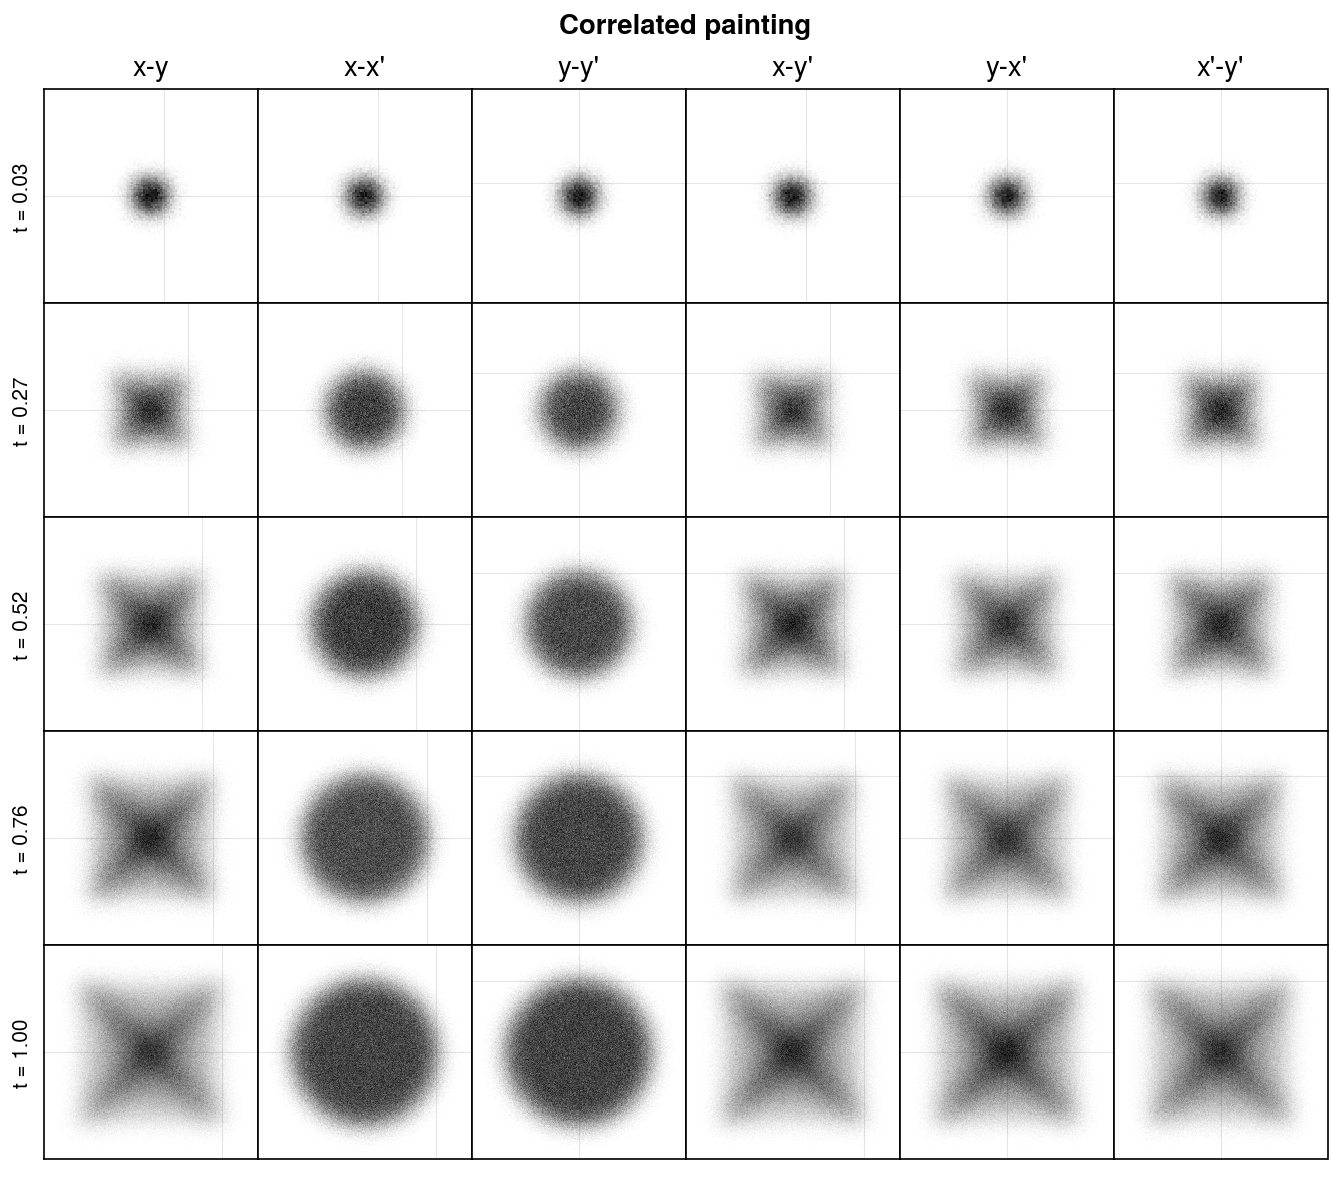

In [11]:
nux = 0.1810201
nuy = nux - 0.143561
n_turns = 3000
turns_list = np.linspace(100, n_turns - 1, 5).astype(int)
painter = Painter(n_turns)
painter.set_xmax([1.0, 0.0, 0.0, 1.0])

method = 'correlated'
coords = [painter.paint(nux, nuy, turns, method) for turns in turns_list]
axs = plot_projections(coords, method, painter)
axs.format(suptitle='Correlated painting')

All plots are shown in the rest frame of the circulating beam at a fixed position in the ring; new particles are injected at the intersection of the faint horizontal and vertical lines. The reason for the square root time-dependence was to create the uniform density ellipses in $x$-$x'$ and $y$-$y'$. The $x$-$y$ distriubtion is rectangular because of the unequal tunes. Interestingly, there are nonzero higher-order correlations between $x$ and $y$, as seen in the higher density cross. The distribution will not look exactly like this during real injection since space charge and other nonlinear effects will perturb the particle oscillations; however, this large peak density is not ideal. For example, at the Spallation Neutron Source (SNS), it is important to minimize the peak density of the beam when it collides with the liquid mercury target. Also, the electric field within the beam in the figure has a nonlinear dependence on the particle coordinates, leading to other undesirable effects. Therefore, the SNS uses correlated painting with an initial offset, creating a hollow beam that eventually fills in during accumulation. The final beam has a more uniform density.

Let's now look at anti-correlated painting.

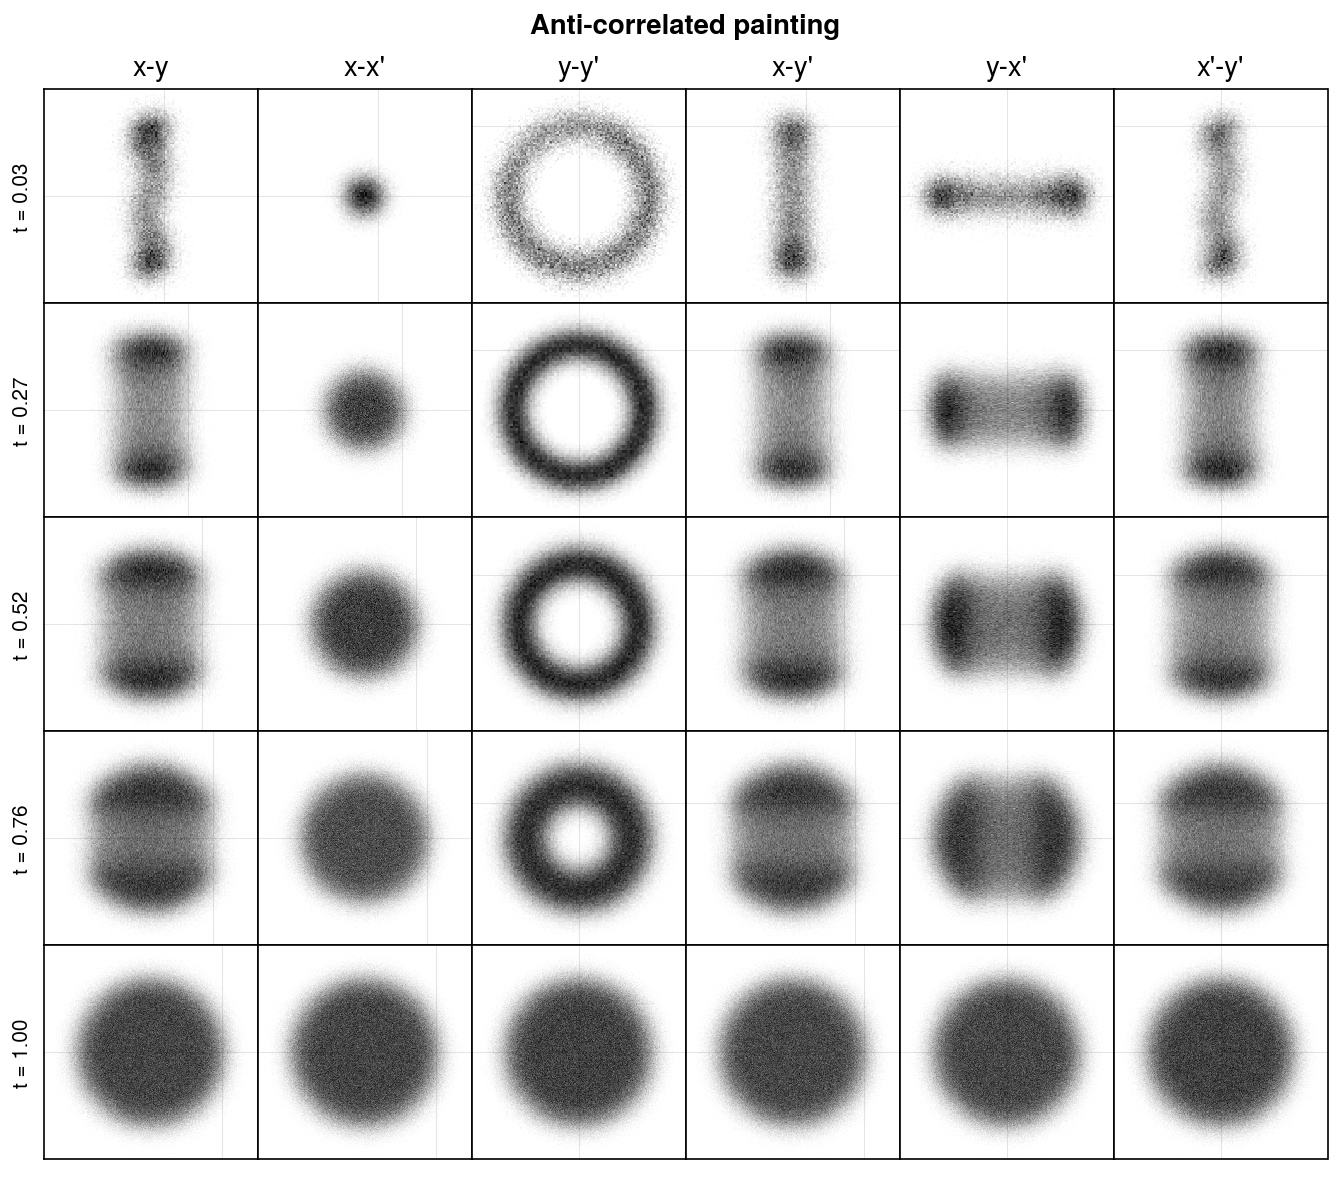

In [12]:
#collapse
method = 'anti-correlated'
coords = [painter.paint(nux, nuy, turns, method) for turns in turns_list]
axs = plot_projections(coords, method, painter)
axs.format(suptitle='Anti-correlated painting')

Incredibly, although the distribution has a strange shape in the $x$-$y$ plane throughout injection, the end result is a uniform density ellipse. In fact, it is an approximate KV distribution in which particles are uniformly spaced on a 4D ellipsoid in phase space. Since the KV distribution linearizes the space charge force, this painting method seems very attractive. But when space charge is included during injection, the nonlinear forces at early times during injection will not preserve the KV structure. Nonetheless, anti-correlated painting can have benefits over correlated painting.

We have been studying an alternative painting method called *elliptical painting*. In elliptical painting, the injected coordinates are scaled along an eigenvector of the ring transfer matrix.

$$
\mathbf{x}(t) = Re \{ \sqrt{2 J_l} \mathbf{v}_l e^{-i\psi_l}  \} \sqrt{t}.
$$


Here $\mathbf{x} = (x, x', y, y')^T$, $\mathbf{v}_l$ is the eigenvector, $J_l$ is an amplitude, $\psi_l$ is a phase, $Re\{z\}$ selects the real component of $z$, and $l = 1,2$. This method takes advantage of coupled motion in the ring and generates a Danilov distribution, which has many of the same attractive properties as the KV distribution. The main difference is that it has angular momentum. 

There is more to say about this method, but for now, let's just look at the distribution it creates in the linear approximation. One way to perform elliptical painting is by setting equal tunes in the ring. In this case, one eigenvector is $\mathbf{v} = (x_{max}, 0, 0, y_{max}')^T$. 

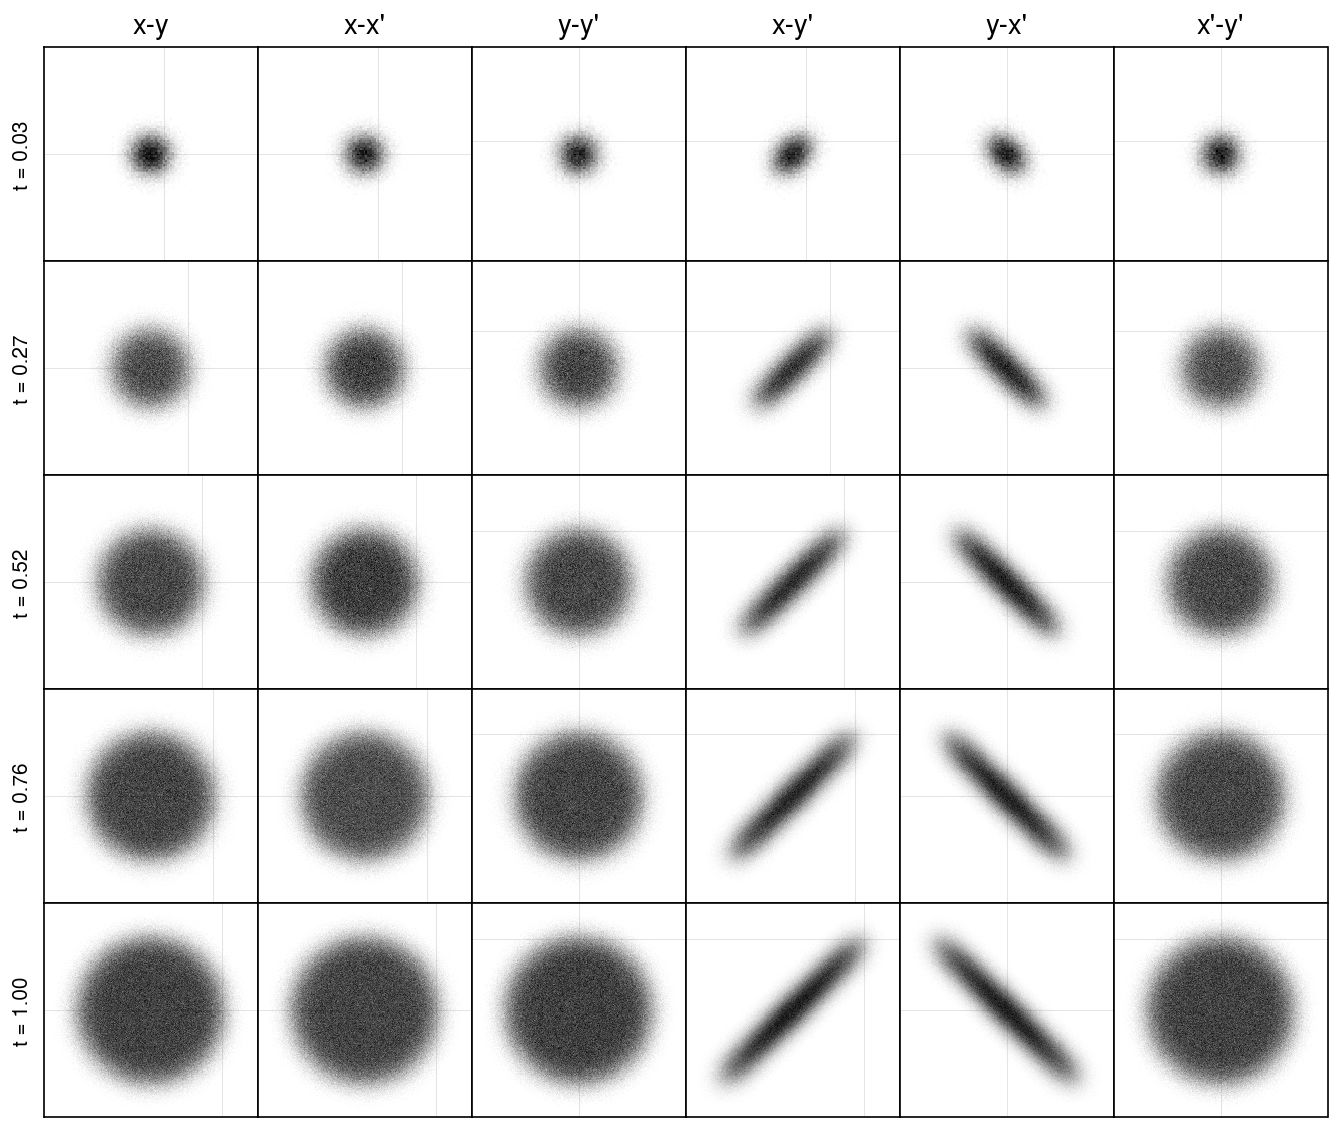

In [13]:
method = 'correlated'
painter.set_xmax([1.0, 0.0, 0.0, 1.0])
coords = [painter.paint(nux, nux, turns, method) for turns in turns_list]
axs = plot_projections(coords, method, painter)

The big change is that we are now varying the angle between the beams — $y'$ in this case — not just the distance. This produces rotation; the beam is rigidly rotating counterclockwise in the above figure. Again, the end result is a uniform density ellipse in the $x$-$y$ plane. But notice the difference from anti-correlated painting: the uniform density ellipse is maintained at all times. In fact, the Danilov structure is maintained at all times. For this reason, an approximate Danilov distribution would be produced *even with space charge*. In fact, realistic simulations predict that this would remain true even with realistic nonlinear effects. This is good news because the Danilov distribution has even more attractive properties than the KV distribution. We are in the midst of testing this prediction at the SNS.